# Lets place this notebook in the root directory

In [1]:
import os
path = %pwd
if path.split(os.sep)[-1] == 'notebooks':
    %cd ..

/home/studio-lab-user/sagemaker-studiolab-notebooks/projects/klee_project_audio


Lets also refresh all our dependecies in run time

In [2]:
%reload_ext autoreload
%autoreload 2

load environment variables, if they exist

In [3]:
from dotenv import load_dotenv

load_dotenv(".env_consts")

True

# Imports

In [48]:
# -------------------------------- torch stuff ------------------------------- #
import torch

# ----------------------------------- other ---------------------------------- #
from tqdm import tqdm
import wandb

# ---------------------------------- Custom ---------------------------------- #
from src.load_dataset_fft import get_splitter_dataloaders_fft

# Get data

In [49]:
F16 = torch.float16
F32 = torch.float32
F64 = torch.float64
FTYPE = F32
TRAIN_SPLIT = float(os.getenv('KLEE_TRAIN_SPLIT', 0.8))
BATCH_SIZE = int(os.getenv('KLEE_BATCH_SIZE', 32))
kwargs = {
        "BATCH_SIZE": BATCH_SIZE,
        "TRAIN_SPLIT": TRAIN_SPLIT,
        "FTYPE": FTYPE,
        "fft_nperseg": 400,
        "fft_noverlap": 240,
        "fft_window_type": "tukey",
        "fft_in_db": True,
        }
print("kwargs : ",kwargs)
train_loader, val_loader, data = get_splitter_dataloaders_fft(**kwargs)

kwargs :  {'BATCH_SIZE': 32, 'TRAIN_SPLIT': 0.8, 'FTYPE': torch.float32, 'fft_nperseg': 400, 'fft_noverlap': 240, 'fft_window_type': 'tukey', 'fft_in_db': True}


Caching dataset: 100%|██████████| 5720/5720 [00:40<00:00, 142.74it/s]


### debug

In [50]:
for i in range(1500):
    if np.isnan(data[i][0].sum()):
        print(i)
        break

tensor(1370.4944)


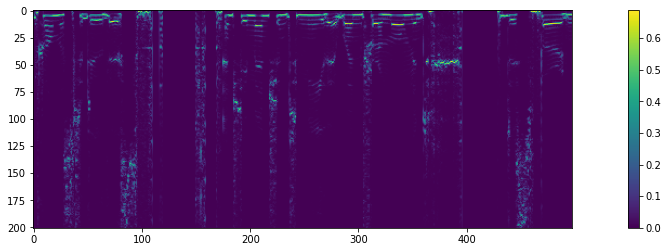

In [54]:
import matplotlib.pyplot as plt 
import numpy as np
import scipy
fft, _ = data[1040]
print(fft.sum())
plt.figure(figsize=(20, 4))
plt.imshow(fft[0])
plt.colorbar()
plt.show()

In [55]:
example, lab = train_loader.dataset[0]
example.shape  # (channel, frequency, time)

torch.Size([1, 201, 498])

# WandB

In [56]:
wandb.init(project="klee_project_audio", entity="mustapha")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mustapha (use `wandb login --relogin` to force relogin)


# Original model CRNN

### Create model

In [57]:
class PermuteForLSTM(torch.nn.Module):
    """
    Permute the input from (batch, channel, freq, time) to (batch, time, freq, channel)
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.permute(0, 3, 2, 1)
    

class ReshapForLSTM(torch.nn.Module):
    """
    Reshape the input from (batch, time, freq, channel) to (batch, time, freq*channel)
    """
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.reshape(x.shape[0], x.shape[1], -1)

class SequentialLSTM(torch.nn.Module):
    """
    LSTMs in Pytorch, outputs a tuple (output, (h_n, c_n)), we only need output
    """
    def __init__(self, input_size=1280, hidden_size=40, num_layers=1, dropout=0):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout)
    def forward(self, x):
        x, _ = self.lstm(x)
        return x

In [58]:
# torch sequential
class Parameters():
    def __init__(self, parameters):
        self.__dict__.update(parameters)

def CRNN(p):
    return torch.nn.Sequential( #input size = 80000
        torch.nn.Conv2d(1, 64, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.Conv2d(64, 32, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=3),
        
        torch.nn.Conv2d(32, 128, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.Conv2d(128, 64, kernel_size=3),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size=3, stride=3),
        
        torch.nn.Dropout(p.dropout),
        #permute 3 with 1
        PermuteForLSTM(),
        ReshapForLSTM(),
        SequentialLSTM(1280, 40), # 1280 = 20 freq *64 channels
        torch.nn.Tanh(),
        torch.nn.MaxPool1d(kernel_size=2, stride=2),
        
        
#         torch.nn.Conv2d(64, 64, kernel_size=5, stride=5),
#         torch.nn.ReLU(),
        
        
        torch.nn.Flatten(),
        torch.nn.Linear(53*20, 11), # Original contains 52*20, I don't know why !
        torch.nn.Softmax(dim=1)        
        
#         torch.nn.Linear(2560, 11), # Original contains 52*20, I don't know why !
#         torch.nn.Softmax(dim=1)
    )

params = Parameters({
    "dropout": 0.2,
})
model = CRNN(params)

In [59]:
model(example.unsqueeze(0)).shape

torch.Size([1, 11])

### Train model

In [60]:
LEARNING_RATE = 1e-3
EPOCHS = 700
MODEL_DROPOUT = params.dropout
EVAL_EACH = 10

wandb.config.update({
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "MODEL" : "RCNN",
    "MODEL_DROPOUT": MODEL_DROPOUT,
    "OPTIMIZER": "ADAM",
    # "batch_size": BATCH_SIZE,
    **kwargs
})

In [ ]:
mae = torch.nn.L1Loss()
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.to("cuda")

# wandb.watch(model, log_freq=1)
for epoch in range(EPOCHS):
    # -------------------------------- Train loop -------------------------------- #
    train_mean_loss = 0
    train_mean_count_loss = 0
    for d in tqdm(train_loader, "training loop"):
        audios = d[0].to("cuda")
        labels = d[1]
        # one hot encode labels
        count_labels = labels.sum(axis=1)
        one_hot_label = torch.eye(11)[count_labels].to("cuda")
        # forward pass
        predictions = model.forward(audios)
        # count loss
        count_loss_value = loss(predictions, one_hot_label)
        train_mean_count_loss += count_loss_value.item()
        #optimize
        optimizer.zero_grad()
        count_loss_value.backward()
        optimizer.step()
    print("Epoch {}/{}".format(epoch+1, EPOCHS))
    print("Train count Loss : {:.4f}".format(train_mean_count_loss/len(train_loader)))
    log = {
        "CrossEntropy_train_count_loss":train_mean_count_loss/len(train_loader),
        "epoch":epoch
        }
    # --------------------------------- Eval loop -------------------------------- #
    if (epoch+1)%EVAL_EACH == 0:
        val_mean_loss = 0
        val_mean_count_loss = 0
        model.eval()
        for d in tqdm(val_loader, "evaluation loop"):
            audios = d[0].to("cuda")
            labels = d[1]
            # one hot encode labels
            count_labels = labels.sum(axis=1)
            one_hot_label = torch.eye(11)[count_labels].to("cuda")
            # forward pass
            predictions = model.forward(audios)
            # count loss
            count_loss_value = mae(predictions, one_hot_label)
            val_mean_count_loss += count_loss_value.item()
        model.train()
        log["MAE_val_count_loss"] = val_mean_count_loss/len(val_loader)
        print("validation count Loss : {:.4f}".format(val_mean_count_loss/len(val_loader)))
        
    wandb.log(log)

training loop: 100%|██████████| 143/143 [00:39<00:00,  3.66it/s]


Epoch 1/700
Train count Loss : 2.3792


training loop: 100%|██████████| 143/143 [00:39<00:00,  3.63it/s]


Epoch 2/700
Train count Loss : 2.2714


training loop: 100%|██████████| 143/143 [00:39<00:00,  3.59it/s]


Epoch 3/700
Train count Loss : 2.2370


training loop:  87%|████████▋ | 124/143 [00:34<00:05,  3.55it/s]

In [ ]:
for m in model.named_modules():
    if m[0] == "0":
        print(list(m[1].parameters()))